<a href="https://colab.research.google.com/github/jsebastianquiroga/DEEP_LEARNING_PUJ/blob/main/RNN_Forecast/googl_msft_aapl_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: center; padding-right: 10px;" src="https://www.pikpng.com/pngl/b/467-4670553_universidad-javeriana-esslingen-am-neckar-clipart.png" width="100" height="150">



<h1> <strong>Aprendizaje Profundo.</strong></h1> 
<h2> Para: Ing. Julio Omar Palacio Niño, M.Sc.</br></h2>
<h2>Integrantes:</br></h2>
<h2>Antonio Jose Caicedo.</br></h2>
<h2>Juan Sebastián Quiroga Bernal. </h2>
<h2>Leonardo García.</br></h2>

**Este colab puede ser ejecutado por cualquier usuario sin necesidad de cargar los archivos al entorno, debido a que la conexión está configurada para acceder a los archivos desde la nube**.

<h1> <strong>Taller 2: Predicción del Precio Más Alto de Acciones con Modelos Recurrentes.</strong></h1> 

En este notebook exploraremos diferentes propuestas de modelos recurrentes para la predicción del precio más alto de las acciones de Google (GOOGL), Microsoft (MSFT) y Apple (AAPL). Para ello, utilizaremos un conjunto de datos de los precios históricos de estas acciones, que contiene datos diarios incluyendo el precio de apertura, cierre, máximo, mínimo y volumen de operaciones.

El conjunto de datos se encuentra dividido en un conjunto de entrenamiento y un conjunto de prueba. En este notebook, implementaremos diferentes arquitecturas de modelos recurrentes utilizando la biblioteca Keras, incluyendo RNNs, LSTM, GRU y Transformers, y evaluaremos su rendimiento en términos de error de predicción.

El objetivo de este proyecto es explorar diferentes técnicas y arquitecturas de modelos recurrentes para mejorar la precisión de la predicción del precio más alto de estas acciones.

Los datos históricos de las acciones pueden ser obtenidos de diferentes fuentes, una opción recomendable es Yahoo Finance: 
- GOOGL: https://finance.yahoo.com/quote/GOOGL/history
- MSFT: https://finance.yahoo.com/quote/MSFT/history
- AAPL: https://finance.yahoo.com/quote/AAPL/history

El presente notebook, estará dividido en las siguientes partes:
<ol>
<li> Carga y preparación del conjunto de datos. </li>
<li> Exploración del conjunto de datos y su comprensión. </li>
<li> Transformación y preparación de datos. </li>
<li> Implementación y entrenamiento del modelo RNN. </li>
<li> Implementación y entrenamiento del modelo LSTM. </li>
<li> Implementación y entrenamiento del modelo GRU. </li>
<li> Implementación y entrenamiento del modelo Transformer. </li>
<li> Análisis de resultados de los modelos. </li>
<li> Bonus: Mejora de los modelos. </li>
</ol>


 <a id="carque"></a>
# 1. Cargue del data set.


con base a poder predecir el valor de las acciones de los tres gigantes  de tecnologia, se conecta con la API de yahoo para traer los ultimo cinco años de información pero como se usara como asistente de inversion, se quiere modelar los valores de venta maximos.

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [3]:
import yfinance as yf

# Define the tickers for the stocks you're interested in
tickers = ['GOOGL', 'MSFT', 'AAPL']

# Define the period for which you want data
period = '5y'  # 5 years

# Fetch the data
data = yf.download(tickers, period=period)
data = data[['High']].reset_index()
data.columns = ['Date', 'AAPL', 'GOOGL', 'MSFT']
data

[*********************100%***********************]  3 of 3 completed


,Date,AAPL,GOOGL,MSFT
0,2018-05-29,47.187500,54.067001,98.879997
1,2018-05-30,47.000000,53.949501,99.250000
2,2018-05-31,47.057499,55.500000,99.989998
3,2018-06-01,47.564999,56.908001,100.860001
4,2018-06-04,48.355000,57.893002,101.860001
...,...,...,...,...
1254,2023-05-22,174.710007,126.430000,322.589996
1255,2023-05-23,173.380005,124.629997,322.720001
1256,2023-05-24,172.419998,121.910004,316.500000
1257,2023-05-25,173.899994,125.320000,326.899994


Se tienen un total de 1259 datos, el cual se utilizara los ultimos 90 dias para predeccir y el restante para el entrenamiento del modelo

# 2. Exploración del conjunto de datos y su comprensión.

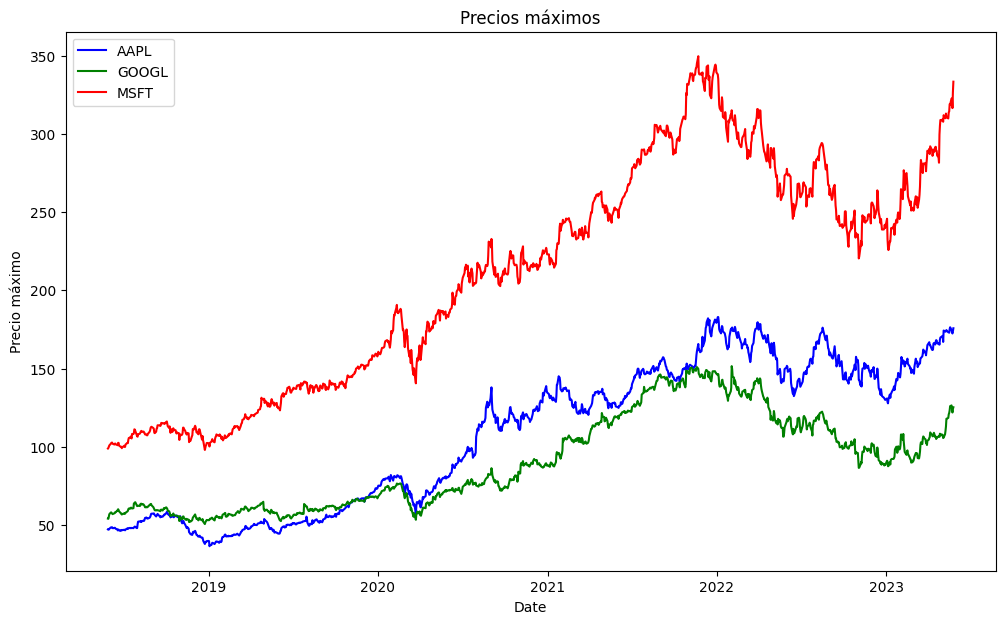

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Define colors for each stock
colors = ['blue', 'green', 'red']

# Plotting
plt.figure(figsize=(12, 7))

# Line plot for each stock with specified colors
line_AAPL = sns.lineplot(data=data, x="Date", y="AAPL", color=colors[0])
line_GOOGL = sns.lineplot(data=data, x="Date", y="GOOGL", color=colors[1])
line_MSFT = sns.lineplot(data=data, x="Date", y="MSFT", color=colors[2])

plt.ylabel("Precio máximo")
plt.title("Precios máximos")

# Create custom legend handles with specified colors
legend_elements = [
    Line2D([0], [0], color=colors[0], label='AAPL'),
    Line2D([0], [0], color=colors[1], label='GOOGL'),
    Line2D([0], [0], color=colors[2], label='MSFT')
]

# Add custom legend handles to the plot
plt.legend(handles=legend_elements)
plt.show()


visulamente se observa como tienen una relación similar en los ultomos años, el valor mas alto de negociacion de Microsoft siempre ha sido muy superior al de sus otros dos competidores

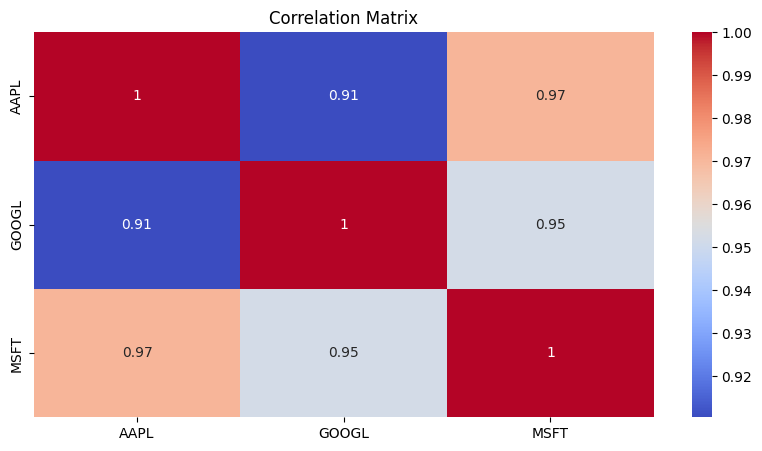

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10,5))

# Correlation matrix
corr = data[['AAPL', 'GOOGL', 'MSFT']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Relacionado con el grafico de tendencia que se percibe, se identifica una alta correción entre estos activos, argumentando lo que visualmente se observa en el grafico de tendencia.

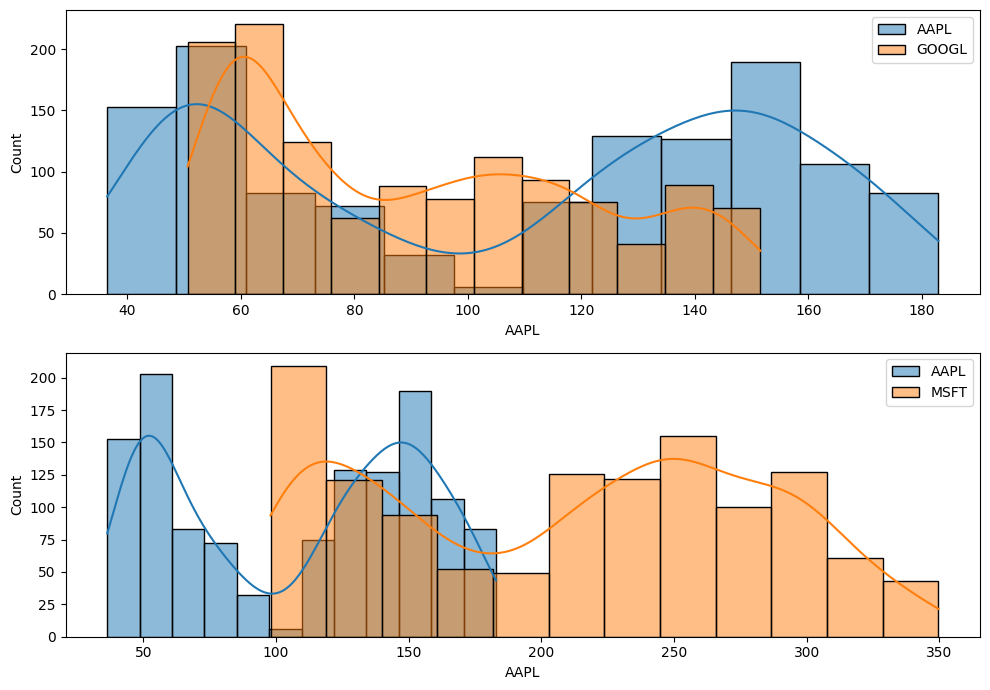

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['GOOGL', 'MSFT']

for i, stock in enumerate(stocks):
    sns.histplot(data['AAPL'], kde=True, label='AAPL', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

Se identifica que la distribución de los precios maximos difiere basntante que la de sus competidores, y el grafico KDE  se puede observar como la distirbuición de probabilidad de Appel es mas similar a google que la de microsoft 

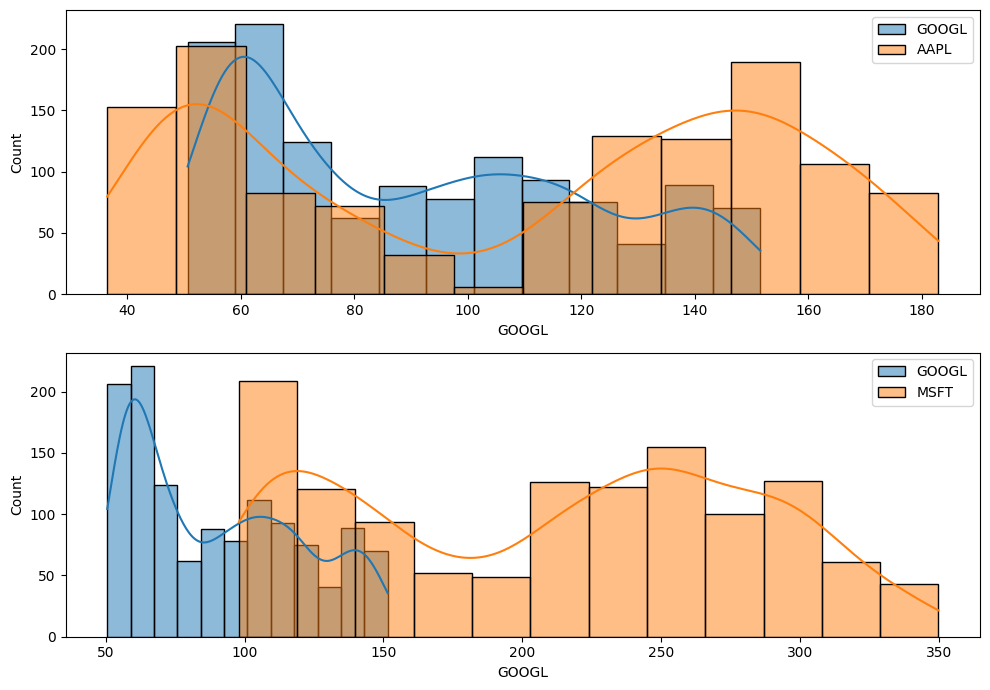

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['AAPL', 'MSFT']

for i, stock in enumerate(stocks):
    sns.histplot(data['GOOGL'], kde=True, label='GOOGL', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

La distribuicion de probabilidad y de Google mantiene la relacion con Apple pero al igual que este diverge mucho de microsoft

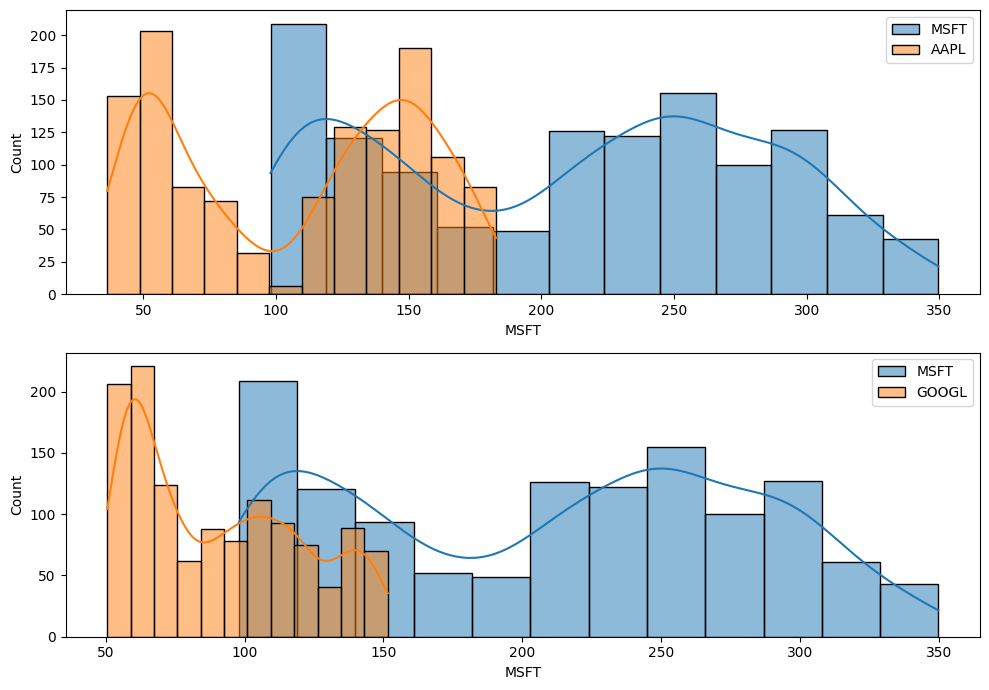

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(10,7))

stocks = ['AAPL', 'GOOGL']

for i, stock in enumerate(stocks):
    sns.histplot(data['MSFT'], kde=True, label='MSFT', ax=axes[i])
    sns.histplot(data[stock], kde=True, label=stock, ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

La distribuciones de microsoft son muy diferente a la de sus dos competidores antes mencionado.

In [9]:
from scipy.stats import ks_2samp

# Calculate KS statistic between AAPL and each other stock
for stock in ['GOOGL', 'MSFT']:
    stat, p = ks_2samp(data['AAPL'], data[stock])
    print(f'KS test between AAPL and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

# Calculate KS statistic between AAPL and each other stock
for stock in ['AAPL', 'MSFT']:
    stat, p = ks_2samp(data['GOOGL'], data[stock])
    print(f'KS test between GOOGL and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

# Calculate KS statistic between AAPL and each other stock
for stock in ['AAPL', 'GOOGL']:
    stat, p = ks_2samp(data['MSFT'], data[stock])
    print(f'KS test between MSFT and {stock}:')
    print(f'Statistic: {stat}')
    print(f'p-value: {p}\n')

KS test between AAPL and GOOGL:
Statistic: 0.329626687847498
p-value: 6.182068383896338e-61

KS test between AAPL and MSFT:
Statistic: 0.6211278792692613
p-value: 1.6935105449790282e-227

KS test between GOOGL and AAPL:
Statistic: 0.329626687847498
p-value: 6.182068383896338e-61

KS test between GOOGL and MSFT:
Statistic: 0.6949960285941224
p-value: 2.660453339930895e-291

KS test between MSFT and AAPL:
Statistic: 0.6211278792692613
p-value: 1.6935105449790282e-227

KS test between MSFT and GOOGL:
Statistic: 0.6949960285941224
p-value: 2.660453339930895e-291



Los resultados anteriores provienen de la prueba de Kolmogorov-Smirnov (KS), que es una prueba no paramétrica que compara las distribuciones de dos conjuntos de datos. En este caso, parece que estamos comparando la distribución de los precios de las acciones de Apple (AAPL), Google (GOOGL) y Microsoft (MSFT).

Los resultados del test KS muestran valores estadísticos notables y p-valores extremadamente bajos en todas las comparaciones. Un p-valor muy bajo (significativamente menor a 0.05) sugiere que podemos rechazar la hipótesis nula de que las dos distribuciones son idénticas. En otras palabras, sugiere que hay una diferencia significativa entre las distribuciones de precios de las acciones de estas compañías.

Observamos que la estadística KS es mayor cuando comparamos MSFT y GOOGL (0.6934), y MSFT y AAPL (0.6195), lo que sugiere que las distribuciones de los precios de las acciones de MSFT y de estas dos compañías son las que tienen mayores diferencias. En contraste, las distribuciones de los precios de las acciones de AAPL y GOOGL son las que menos difieren, con una estadística KS de 0.3296.

En resumen, estos resultados nos sugieren que las distribuciones de precios de las acciones de estas tres compañías son significativamente diferentes entre sí, con las mayores diferencias observadas entre MSFT y las otras dos compañías.

# 3. Transformación y preparación de datos:

Se realizo una serie de trasnformaciones para prepara los datos para su uso en un modelo de predicción de series de tiempo. En primer lugar, se normalizan los datos utilizando el escalador MinMaxScaler para asegurar que estén en el rango de 0 a 1. A continuación, se dividen los datos en bloques de entrenamiento, validación y prueba utilizando la validación cruzada en bloque. Se preparan las secuencias de entrada y los valores objetivo correspondientes para cada bloque. Los datos de prueba se utilizan como ejemplo para mostrar la forma de las secuencias y los valores objetivo. Se establece cadenas de 90 dias, ya que modelos como el Transformes que sera nuestra ultima propuesta, necesita que las dimenciones de entrada sean iguales que las de entrada.

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define el número de días a predecir
prediction_days = 30
# Define el tamaño de la secuencia
sequence_length = 90
# Define el número de bloques para la Validación cruzada en bloque
num_blocks = 5  # Por ejemplo, dividir en 5 bloques de tiempo




# Obtener las columnas numéricas para la normalización
numeric_columns = ['AAPL', 'GOOGL', 'MSFT']
# Realizar la normalización de los datos
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])
# Calcula el tamaño de cada bloque para los conjuntos de entrenamiento y validación
block_size = (len(scaled_data) - sequence_length - prediction_days) // num_blocks


# Inicializa listas para almacenar los resultados de la validación cruzada
train_input_list = []
train_target_list = []
val_input_list = []
val_target_list = []
test_input_list = []
test_target_list = []

# Prepara los datos de entrenamiento y prueba en secuencias
def create_sequences(data, sequence_length, prediction_days):
    input_sequences = []
    target_sequences = []

    for i in range(len(data) - sequence_length - prediction_days + 1):
        input_sequences.append(data[i:i+sequence_length])
        target_sequences.append(data[i+sequence_length:i+sequence_length+prediction_days])

    return np.array(input_sequences), np.array(target_sequences)

# Realiza la Validación cruzada en bloque
for i in range(num_blocks - 1):  # Iterar solo hasta num_blocks - 1
    # Divide los datos en bloques de entrenamiento y validación
    start_index = i * block_size
    end_index = (i + 1) * block_size

    train_data = np.concatenate((scaled_data[:start_index], scaled_data[end_index:]), axis=0)

    # Divide el bloque de entrenamiento en entrenamiento y validación
    val_size = len(train_data) // num_blocks
    val_data = train_data[-val_size:]
    train_data = train_data[:-val_size]

    # Prepara los datos de entrenamiento y validación en secuencias
    train_input, train_target = create_sequences(train_data, sequence_length, prediction_days)
    val_input, val_target = create_sequences(val_data, sequence_length, prediction_days)

    # Almacena las secuencias y valores objetivo en listas
    train_input_list.append(train_input)
    train_target_list.append(train_target)
    val_input_list.append(val_input)
    val_target_list.append(val_target)

# Obtén los últimos 90 días para el conjunto de prueba
test_data = scaled_data[-(sequence_length + prediction_days):]

# Prepara los datos de prueba en secuencias
test_input, test_target = create_sequences(test_data, sequence_length, prediction_days)

# Almacena las secuencias y valores objetivo de prueba
test_input_list.append(test_input)
test_target_list.append(test_target)

# Combina todas las secuencias y valores objetivo
train_input, train_target = create_sequences(train_data, sequence_length, prediction_days)
val_input, val_target = create_sequences(val_data, sequence_length, prediction_days)
test_input, test_target = create_sequences(test_data, sequence_length, prediction_days)

# Muestra de ejemplo de cómo utilizar los datos de prueba

print("Datos de entrenamiento:")
print(train_input.shape)  # Imprime la forma de los datos de prueba
print(train_target.shape)  # Imprime la forma de los valores objetivo de prueba

print("Datos de validación:")
print(val_input.shape)  # Imprime la forma de los datos de prueba
print(val_target.shape)  # Imprime la forma de los valores objetivo de prueba

print("Datos de prueba:")
print(test_input.shape)  # Imprime la forma de los datos de prueba
print(test_target.shape)  # Imprime la forma de los valores objetivo de prueba

Datos de entrenamiento:
(707, 90, 3)
(707, 30, 3)
Datos de validación:
(87, 90, 3)
(87, 30, 3)
Datos de prueba:
(1, 90, 3)
(1, 30, 3)


# modelo 1. Red Feedforward

In [11]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping


model_naive = Sequential()
model_naive.add(Reshape((270,), input_shape=(90,3)))  # Flatten the input tensor
model_naive.add(Dense(10, activation='relu'))
model_naive.add(Dense(50, activation='relu'))
model_naive.add(Dense(3, activation='relu'))
model_naive.add(Dense(30 * 3))  # 30 days * 3 features, without kernel initializer
model_naive.add(Reshape([30, 3]))  # Now reshape will work as expected

model_naive.compile(optimizer='adam', loss='mse')


early_stop = EarlyStopping(patience=15, monitor='val_loss', mode='min')

# Entrenar el modelo con datos de entrenamiento y validación
history_naive = model_naive.fit(
    train_input,
    train_target,
    validation_data=(val_input, val_target),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
23/23 [==============================] - 1s 14ms/step - loss: 0.1774 - val_loss: 0.4271
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1635 - val_loss: 0.3995
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1509 - val_loss: 0.3736
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1398 - val_loss: 0.3505
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1301 - val_loss: 0.3288
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.1214 - val_loss: 0.3088
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.1139 - val_loss: 0.2906
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1072 - val_loss: 0.2734
Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 0.1012 - val_loss: 0.2565
Epoch 10/100
23/23 [==============================] - 0s 5ms/step - loss: 0.0961 - val_loss: 0.2419
Epoch 11

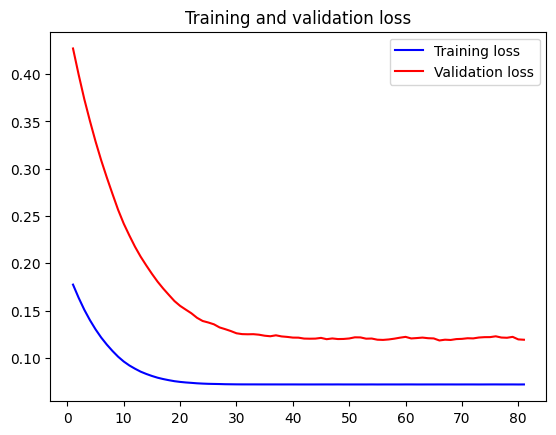

In [12]:
import matplotlib.pyplot as plt

# Get training and validation loss histories from History object
train_loss_na = history_naive.history['loss']
val_loss_na = history_naive.history['val_loss']

# Make epochs array of the same length as training history
epochs = range(1, len(train_loss_na) + 1)

# Plot the loss
plt.figure()
plt.plot(epochs, train_loss_na, 'b', label='Training loss')
plt.plot(epochs, val_loss_na, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [13]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss = model_naive.evaluate(test_input, test_target, verbose=2)
print("Test loss:", test_loss)

Evaluate on test data
1/1 - 0s - loss: 0.2183 - 20ms/epoch - 20ms/step
Test loss: 0.21826976537704468


1/1 [==============================] - 0s 108ms/step


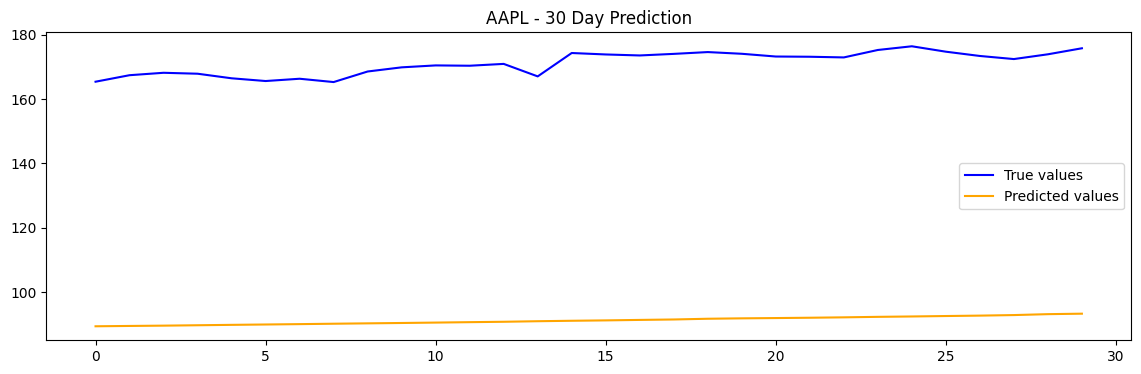

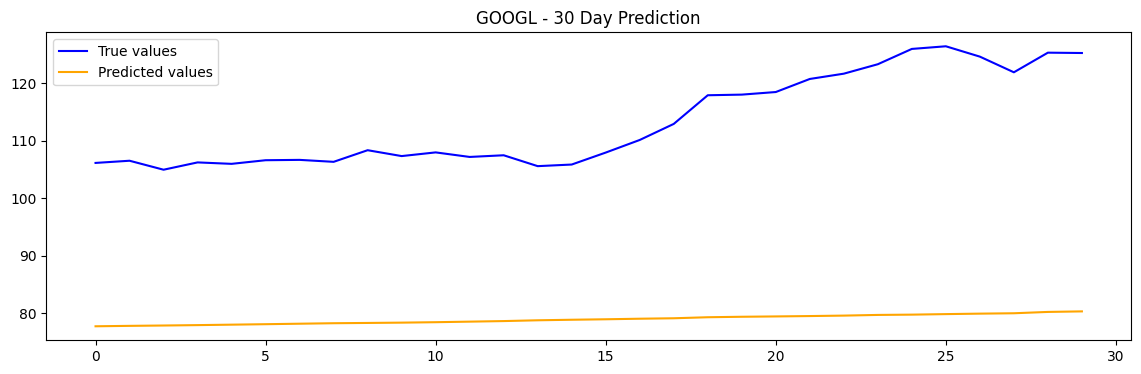

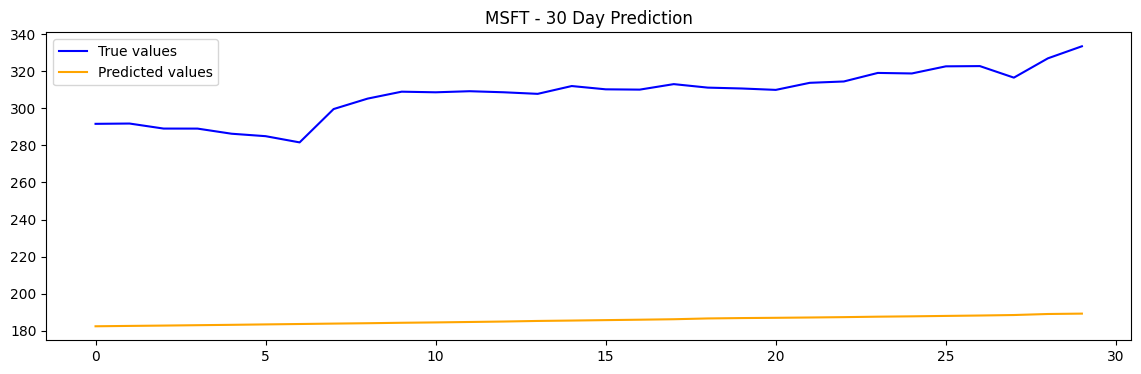

In [14]:
# Toma tus predicciones del modelo y aplícales la transformación inversa
predictions_na = model_naive.predict(test_input)
predictions_na = scaler.inverse_transform(predictions_na.reshape(-1, 3)).reshape(predictions_na.shape)

# Toma tus valores de prueba y aplícales la transformación inversa
true_values = scaler.inverse_transform(test_target.reshape(-1, 3)).reshape(test_target.shape)

# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 4))

    # Plot the true values
    plt.plot(true_values[0, :, i], label="True values", color='blue')

    # Plot the predicted values
    plt.plot(predictions_na[0, :, i], label="Predicted values", color='orange')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()

# Modelo 1: LSTM:

Fue desarrollado un modelo de red recurrente para la predicción de acciones utilizando datos históricos de las acciones de empresas como AAPL, GOOGL y MSFT. El objetivo es utilizar la información histórica de estas acciones para predecir los valores futuros y proporcionar una guía útil para la toma de decisiones financieras.

Nuestro modelo utiliza una arquitectura de red recurrente basada en capas LSTM (Long Short-Term Memory), que es especialmente efectiva en el procesamiento de secuencias de datos. La red se entrena utilizando un conjunto de datos dividido en bloques de tiempo, utilizando la técnica de Validación cruzada en bloque para evaluar su rendimiento en diferentes períodos.

Además, hemos ajustado el modelo para que propague solo hasta t-5, lo que significa que utiliza los últimos cinco pasos de tiempo disponibles para realizar predicciones. Esto nos permite capturar patrones y relaciones relevantes en un horizonte temporal cercano, que pueden ser más informativos para la predicción a corto plazo.

Para evaluar el desempeño del modelo, hemos incluido conjuntos de entrenamiento, validación y prueba, que nos permiten medir su capacidad de generalización a diferentes períodos de tiempo y evitar el sobreajuste.

Esperamos que este modelo de red recurrente para la predicción de series de tiempo de acciones sea una herramienta útil para aquellos interesados en aprovechar el poder de las redes neuronales en el análisis y la predicción de datos financieros.

In [15]:
print(train_input.shape[1], train_input.shape[2])

90 3


In [16]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, GRU
from tensorflow.keras.callbacks import EarlyStopping


print('input shape: ', train_input.shape[1], train_input.shape[2])
# Definir la arquitectura de la red recurrente
model = Sequential()
model.add(LSTM(64, input_shape=(90, 3), return_sequences=False))  # changed return_sequences to False
model.add(Dropout(0.3))
model.add(Dense(32, activation='leaky_relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30 * 3, kernel_initializer=tensorflow.initializers.zeros()))  # 30 days * 3 features
model.add(Reshape([30, 3])) 


model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=15, monitor='val_loss', mode='min')

# Entrenar el modelo con datos de entrenamiento y validación
history = model.fit(
    train_input,
    train_target,
    validation_data=(val_input, val_target),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

input shape:  90 3
Epoch 1/100
23/23 [==============================] - 4s 61ms/step - loss: 0.1355 - val_loss: 0.0604
Epoch 2/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0382 - val_loss: 0.0200
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 0.0201 - val_loss: 0.0186
Epoch 4/100
23/23 [==============================] - 1s 46ms/step - loss: 0.0200 - val_loss: 0.0095
Epoch 5/100
23/23 [==============================] - 1s 45ms/step - loss: 0.0163 - val_loss: 0.0132
Epoch 6/100
23/23 [==============================] - 1s 45ms/step - loss: 0.0170 - val_loss: 0.0088
Epoch 7/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0159 - val_loss: 0.0154
Epoch 8/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0162 - val_loss: 0.0089
Epoch 9/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0168 - val_loss: 0.0095
Epoch 10/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0159

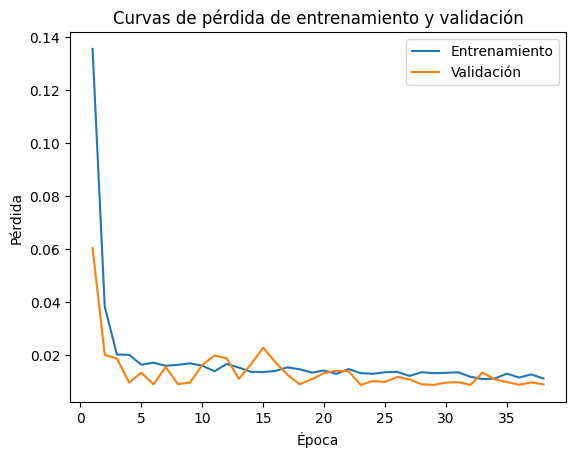

In [17]:
import matplotlib.pyplot as plt

# Obtén las curvas de pérdida de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crea el gráfico
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Entrenamiento')
plt.plot(epochs, val_loss, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()


In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss = model.evaluate(test_input, test_target, verbose=2)
print("Test loss:", test_loss)

Evaluate on test data
1/1 - 0s - loss: 0.0112 - 26ms/epoch - 26ms/step
Test loss: 0.011206266470253468


1/1 [==============================] - 0s 434ms/step


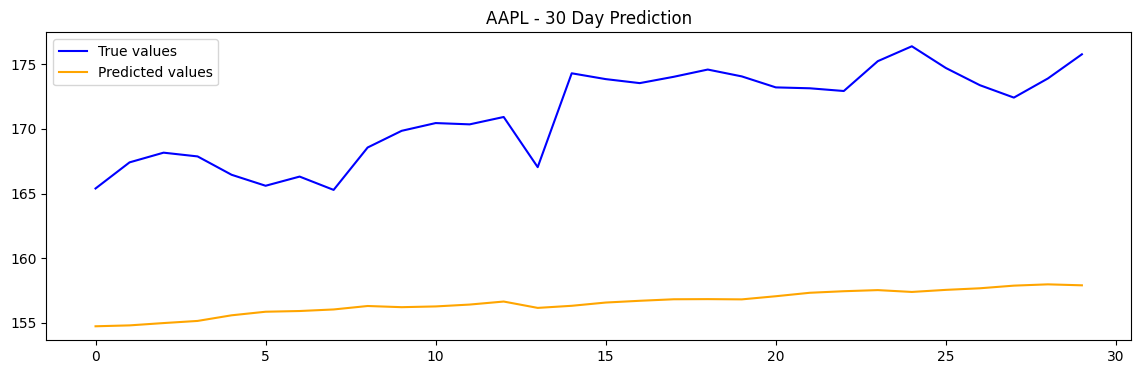

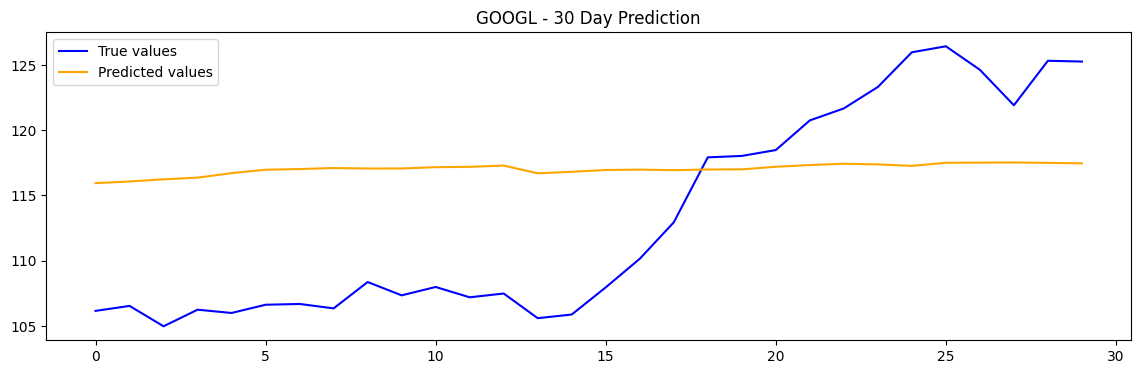

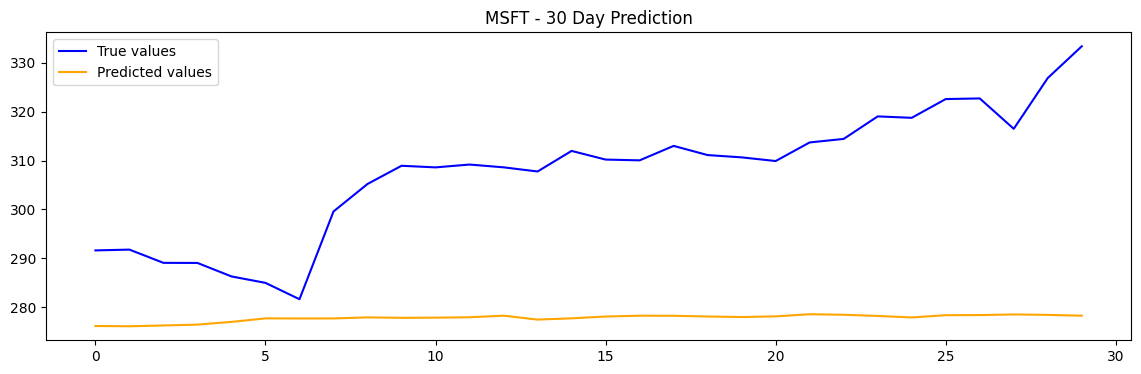

In [19]:
# Toma tus predicciones del modelo y aplícales la transformación inversa
predictions = model.predict(test_input)
predictions = scaler.inverse_transform(predictions.reshape(-1, 3)).reshape(predictions.shape)

# Toma tus valores de prueba y aplícales la transformación inversa
true_values = scaler.inverse_transform(test_target.reshape(-1, 3)).reshape(test_target.shape)

# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 4))

    # Plot the true values
    plt.plot(true_values[0, :, i], label="True values", color='blue')

    # Plot the predicted values
    plt.plot(predictions[0, :, i], label="Predicted values", color='orange')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()

# Modelo 2: GRU:

En este caso, el modelo está basado en una arquitectura de red recurrente utilizando capas GRU (Gated Recurrent Unit), una variante de la LSTM que tiene la misma capacidad para capturar dependencias de largo plazo pero con menos parámetros, lo que la hace más eficiente computacionalmente.

El modelo se construye con tres capas GRU, cada una seguida de una capa de regularización Dropout para evitar el sobreajuste. La primera capa GRU tiene 64 unidades, la segunda 32 y la tercera 16. Todas ellas utilizan la función de activación relu.

Para la entrada, estamos pasando bloques de tiempo de longitud 5, lo que significa que el modelo utiliza los últimos cinco pasos de tiempo disponibles para realizar predicciones, igual que en el modelo LSTM. Esto nos permite capturar patrones y relaciones relevantes en un horizonte temporal cercano, que pueden ser más informativos para la predicción a corto plazo.

La capa de salida es una capa densa con 3 unidades, que se correspondería con la predicción de los valores futuros de tres acciones diferentes.

Para la compilación de la red, utilizamos el optimizador SGD (Stochastic Gradient Descent) con una tasa de aprendizaje de 0.01 y una pérdida de Mean Squared Error, que es una elección común para tareas de regresión.

Además, se utiliza una estrategia de parada temprana durante el entrenamiento para detener el proceso de aprendizaje si el error de validación no mejora después de 10 épocas.

Finalmente, el modelo se entrena utilizando datos de entrenamiento y validación, midiendo su capacidad de generalización en diferentes períodos de tiempo.

Esperamos que este modelo de red recurrente para la predicción de series de tiempo de acciones sea una herramienta útil para aquellos interesados en aprovechar el poder de las redes neuronales en el análisis y la predicción de datos financieros.

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=64, return_sequences=True, input_shape=(90, 3), activation='relu'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=32, return_sequences=True, activation='relu'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=16, return_sequences=False, activation='relu'))  # Changed return_sequences to False
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(30 * 3, kernel_initializer=tensorflow.initializers.zeros()))  # 30 days * 3 features
regressorGRU.add(Reshape([30, 3])) 

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Definimos una tasa de aprendizaje inicial
initial_learning_rate = 0.01

# Definimos la estrategia de decaimiento. En este caso, la tasa de aprendizaje se reducirá
# en un factor de 0.96 cada 100000 pasos.
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Compilamos el modelo
regressorGRU.compile(
    optimizer=SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False),
    loss='mse'
)

# Definimos un callback para detener el entrenamiento cuando no haya mejora
early_stop = EarlyStopping(patience=10, monitor='val_loss', mode='min')

# Entrenamos el modelo con los datos de entrenamiento y validación
history_2 = regressorGRU.fit(
    train_input,
    train_target,
    validation_data=(val_input, val_target),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
23/23 [==============================] - 7s 149ms/step - loss: 0.1814 - val_loss: 0.4418
Epoch 2/100
23/23 [==============================] - 2s 107ms/step - loss: 0.1717 - val_loss: 0.4188
Epoch 3/100
23/23 [==============================] - 2s 106ms/step - loss: 0.1611 - val_loss: 0.3979
Epoch 4/100
23/23 [==============================] - 2s 106ms/step - loss: 0.1518 - val_loss: 0.3774
Epoch 5/100
23/23 [==============================] - 2s 106ms/step - loss: 0.1425 - val_loss: 0.3572
Epoch 6/100
23/23 [==============================] - 3s 121ms/step - loss: 0.1339 - val_loss: 0.3379
Epoch 7/100
23/23 [==============================] - 3s 121ms/step - loss: 0.1257 - val_loss: 0.3168
Epoch 8/100
23/23 [==============================] - 2s 107ms/step - loss: 0.1167 - val_loss: 0.2943
Epoch 9/100
23/23 [==============================] - 3s 111ms/step - loss: 0.1075 - val_loss: 0.2672
Epoch 10/100
23/23 [==============================] - 2s 108ms/step - loss: 0.0976 - val_lo

In [ ]:
import matplotlib.pyplot as plt

# Obtén las curvas de pérdida de entrenamiento y validación del historial
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

# Crea el gráfico
epochs = range(1, len(train_loss_2) + 1)
plt.plot(epochs, train_loss_2, label='Entrenamiento')
plt.plot(epochs, val_loss_2, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de pérdida de entrenamiento y validación')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss_2 = regressorGRU.evaluate(test_input, test_target, verbose=2)
print("Test loss:", test_loss_2)

In [ ]:
# Toma tus predicciones del modelo y aplícales la transformación inversa
predictions_2 = regressorGRU.predict(test_input)
predictions_2 = scaler.inverse_transform(predictions_2.reshape(-1, 3)).reshape(predictions_2.shape)

# Toma tus valores de prueba y aplícales la transformación inversa
true_values_2 = scaler.inverse_transform(test_target.reshape(-1, 3)).reshape(test_target.shape)

# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 4))

    # Plot the true values
    plt.plot(true_values[0, :, i], label="True values", color='blue')

    # Plot the predicted values
    plt.plot(predictions_2[0, :, i], label="Predicted values", color='orange')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()

# 3. Modelo Transformer

 Este modelo consta de capas de codificación y decodificación. La capa de codificación se compone de capas de encoders Transformer, mientras que la capa de decodificación está formada por capas de decodificadores Transformer. El modelo utiliza una capa completamente conectada para la salida final.

Durante el entrenamiento, se utiliza la función de pérdida de error cuadrático medio (MSELoss) y el optimizador Adam para ajustar los pesos del modelo. Los datos de entrenamiento y validación se convierten en tensores de PyTorch y se mueven al dispositivo (GPU o CPU) según su disponibilidad.

El modelo se entrena durante un número especificado de épocas, y en cada época se realiza un pase hacia adelante (forward pass) y un pase hacia atrás (backward pass) para ajustar los pesos. Después de cada época, se evalúa el desempeño del modelo en los datos de validación y se registra la pérdida obtenida. Se implementa un mecanismo de parada temprana basado en la paciencia, que detiene el entrenamiento si la pérdida de validación no mejora durante un número determinado de épocas.

En resumen, este modelo Transformer es utilizado para la predicción de series de tiempo y se entrena utilizando datos de entrenamiento y validación. El proceso de entrenamiento se detiene tempranamente si no se observa mejora en la pérdida de validación. Este modelo proporciona una herramienta efectiva para modelar y predecir series de tiempo en diversas aplicaciones.

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, output_length, dropout=0.3):
        super(TimeSeriesTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=dropout),
            num_layers
        )
        self.middle_linear = nn.Linear(d_model*90, d_model*30)
        self.dropout = nn.Dropout(dropout)
        self.output_proj = nn.Linear(d_model*30, input_dim*output_length)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # flatten the output
        x = self.dropout(x)  # apply dropout
        x = self.middle_linear(x)
        x = self.dropout(x)  # apply dropout
        x = self.output_proj(x)
        return x.view(x.size(0), -1, 3)  # restore to (batch_size, seq_length, feature_dim)


In [ ]:
# Crear el modelo
input_dim = 3  # Dimensión de entrada
d_model = 64  # Dimensión de embedding
nhead = 8  # Número de cabezas de atención
num_layers = 8  # Número de capas
dim_feedforward = 150  # Dimensión de la capa feedforward en el Transformer
output_length = 30  # Longitud de la secuencia de salida
patience = 25  # Número de épocas para esperar antes de detenerse si no hay mejoras
best_val_loss = float('inf')  # Mejor pérdida de validación hasta ahora
epochs_without_improvement = 0  # Número de épocas sin mejora

model_tr = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dim_feedforward, output_length)
optimizer = AdamW(model_tr.parameters(), lr=1e-3, weight_decay=0.01)
###################
from torch.nn import MSELoss

# Convertir los datos a tensores de PyTorch
train_inputs = torch.tensor(train_input, dtype=torch.float32)
train_targets = torch.tensor(train_target, dtype=torch.float32)
val_inputs = torch.tensor(val_input, dtype=torch.float32)
val_targets = torch.tensor(val_target, dtype=torch.float32)

# Cargar los datos en un DataLoader
train_dataset = torch.utils.data.TensorDataset(train_inputs, train_targets)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_dataset = torch.utils.data.TensorDataset(val_inputs, val_targets)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Definir la función de pérdida y el optimizador
loss_function = MSELoss()
optimizer = AdamW(model_tr.parameters(), lr=1e-3)

# Mover el modelo a la GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_tr = model_tr.to(device)

# Número de épocas
n_epochs = 100
# Listas para almacenar las pérdidas de entrenamiento y validación
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Entrenar el modelo
    model_tr.train()
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_dataloader):
        # Mover los inputs y targets a la GPU si está disponible
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Limpiar los gradientes del optimizador
        optimizer.zero_grad()

        # Hacer un paso adelante en el modelo
        outputs = model_tr(inputs)

        # Calcular la pérdida
        loss = loss_function(outputs, targets)

        # Hacer un paso atrás (backward pass) y actualizar los pesos
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss}")
    
    # Guardar la pérdida de entrenamiento para esta época
    train_losses.append(avg_train_loss)
    
    # Validar el modelo
    model_tr.eval()
    total_val_loss = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_dataloader):
            # Mover los inputs y targets a la GPU si está disponible
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Hacer un paso adelante en el modelo
            outputs = model_tr(inputs)

            # Calcular la pérdida
            loss = loss_function(outputs, targets)

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f"Epoch {epoch+1}/{n_epochs} | Validation Loss: {avg_val_loss}")

        # Guardar la pérdida de validación para esta época
        val_losses.append(avg_val_loss)

        # Comprobar si la pérdida de validación ha mejorado
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Si la pérdida de validación no ha mejorado durante 'patience' épocas, detener el entrenamiento
        if epochs_without_improvement == patience:
            print("Stopping training due to lack of improvement")
            break

In [ ]:
import matplotlib.pyplot as plt
# Trazar las pérdidas de entrenamiento y validación
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Toma tus predicciones del modelo y aplícales la transformación inversa
test_inputs = torch.tensor(test_input, dtype=torch.float32).to(device)
model_tr.eval()  # Cambia el modelo a modo de evaluación
with torch.no_grad():  # No necesitamos calcular gradientes
    predictions_3 = model_tr(test_inputs)
predictions_3 = predictions_3.cpu().numpy()  # Convertir las predicciones a numpy
predictions_3 = scaler.inverse_transform(predictions_3.reshape(-1, 3)).reshape(predictions_3.shape)

# Toma tus valores de prueba y aplícales la transformación inversa
true_values_3 = scaler.inverse_transform(test_target.reshape(-1, 3)).reshape(test_target.shape)

# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 4))

    # Plot the true values
    plt.plot(true_values[0, :, i], label="True values", color='blue')

    # Plot the predicted values
    plt.plot(predictions_3[0, :, i], label="Predicted values", color='orange')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()

# Comparación.

In [ ]:
# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 6))

    # Plot the true values
    plt.plot(true_values[0, :, i], label="True values", color='blue')

    # Plot the predicted values from LSTM
    plt.plot(predictions[0, :, i], label="LSTM Predicted values", color='orange')

    # Plot the predicted values from GRU
    plt.plot(predictions_2[0, :, i], label="GRU Predicted values", color='green')

    # Plot the predicted values from Transformer
    plt.plot(predictions_3[0, :, i], label="Transformer Predicted values", color='red')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Obtener las predicciones para cada modelo
predictions_LSTM = model.predict(test_input)
predictions_GRU = regressorGRU.predict(test_input)

# Para el modelo Transformer
predictions_transformer = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        outputs = model_tr(inputs)
        predictions_transformer.append(outputs.cpu().numpy())
predictions_transformer = np.concatenate(predictions_transformer)

# Calcular las métricas
metrics = []
for name, predictions in zip(['LSTM', 'GRU', 'Transformer'], [predictions_LSTM, predictions_GRU, predictions_transformer]):
    mae = mean_absolute_error(test_target.flatten(), predictions.flatten())
    rmse = np.sqrt(mean_squared_error(test_target.flatten(), predictions.flatten()))
    r2 = r2_score(test_target.flatten(), predictions.flatten())
    metrics.append([name, mae, rmse, r2])

# Crear un DataFrame para comparar las métricas
df_metrics = pd.DataFrame(metrics, columns=['Model', 'MAE', 'RMSE', 'R2'])

df_metrics

In [ ]:
# propuesta bagging utilizar promedio de modelos, linea morada

# Para cada acción
for i, action in enumerate(numeric_columns):
    # Crea un nuevo plot
    plt.figure(figsize=(14, 6))

    # Plot the true values
    plt.plot(true_values_3[0, :, i], label="True values", color='blue')

    # Plot the predicted values from LSTM
    plt.plot(predictions[0, :, i], label="LSTM Predicted values", color='orange')

    # Plot the predicted values from GRU
    plt.plot(predictions_2[0, :, i], label="GRU Predicted values", color='green')

    # Plot the predicted values from Transformer
    plt.plot(predictions_3[0, :, i], label="Transformer Predicted values", color='red')

    # Calculate the average prediction
    average_prediction = (predictions[0, :, i] + predictions_2[0, :, i] + predictions_3[0, :, i]) / 3

    # Plot the average prediction
    plt.plot(average_prediction, label="Average Predicted values", color='purple')

    # Add a title and legend
    plt.title(f"{action} - 30 Day Prediction")
    plt.legend()

    # Show the plot
    plt.show()
